In [1]:
import torch
from ultralytics import YOLO
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
import os
import matplotlib.patches as patches
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score
from scipy.optimize import linear_sum_assignment

In [2]:
model_path = "runs/detect/train9/weights/best.pt"

model = YOLO(model_path)

In [3]:
base_path = os.path.abspath('individual_project/keyu_dataset')

In [4]:
calibration_image_path = os.path.join(base_path, 'calibration/images')
calibration_labels_path = os.path.join(base_path, 'calibration/labels')


calibration_image_list = [f for f in os.listdir(calibration_image_path) if f.endswith(('.jpeg', '.jpg', '.png'))]
calibration_image_files = [os.path.join(calibration_image_path, img) for img in calibration_image_list]


calibration_label_files = [os.path.join(calibration_labels_path, os.path.basename(f).replace('.jpeg', '.txt').replace('.jpg', '.txt').replace('.png', '.txt')) for f in calibration_image_files]

In [5]:
test_image_path = os.path.join(base_path, 'test/images')
test_labels_path = os.path.join(base_path, 'test/labels')


test_image_list = [f for f in os.listdir(test_image_path) if f.endswith(('.jpeg', '.jpg', '.png'))]
test_image_files = [os.path.join(test_image_path, img) for img in test_image_list]
test_label_files = [os.path.join(test_labels_path, os.path.basename(f).replace('.jpeg', '.txt').replace('.jpg', '.txt').replace('.png', '.txt')) for f in test_image_files]

In [6]:

def load_ground_truths(label_files):
    ground_truths = []
    for label_file in label_files:
        with open(label_file, 'r') as f:
            labels = []
            for line in f:
                class_id, x_center, y_center, width, height = map(float, line.strip().split())
                labels.append([class_id, x_center, y_center, width, height])
            ground_truths.append(labels)
    return ground_truths

In [7]:
calibration_ground_truths = load_ground_truths(calibration_label_files)
test_ground_truths = load_ground_truths(test_label_files)

In [8]:

calibration_predictions = []
for i, image_file in enumerate(calibration_image_files):
    img = cv2.imread(image_file)
    results = model.predict(img)  
    calibration_predictions.append(results)  
    print(f"Processed calibration image {i + 1}/{len(calibration_image_files)}")


0: 512x512 2 trucks, 1 car, 4 pedestrians, 1 biker, 773.8ms
Speed: 1.8ms preprocess, 773.8ms inference, 24.1ms postprocess per image at shape (1, 3, 512, 512)
Processed calibration image 1/3154

0: 512x512 1 truck, 6 cars, 2 pedestrians, 3 trafficLight Greens, 676.2ms
Speed: 1.1ms preprocess, 676.2ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 512)
Processed calibration image 2/3154

0: 512x512 2 cars, 1 trafficLight Red, 679.3ms
Speed: 1.0ms preprocess, 679.3ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 512)
Processed calibration image 3/3154

0: 512x512 2 cars, 710.5ms
Speed: 1.1ms preprocess, 710.5ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 512)
Processed calibration image 4/3154

0: 512x512 1 truck, 6 cars, 675.3ms
Speed: 1.0ms preprocess, 675.3ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 512)
Processed calibration image 5/3154

0: 512x512 5 cars, 3 pedestrians, 2 trafficLight Reds, 2 trafficLight RedLefts, 689.

In [9]:
### ADD


def calculate_Rk_add(pred_box, gt_box):
    delta_x_min = pred_box[0] - gt_box[0]
    delta_y_min = pred_box[1] - gt_box[1]
    delta_x_max = gt_box[2] - pred_box[2]
    delta_y_max = gt_box[3] - pred_box[3]
    R_k = (delta_x_min, delta_y_min, delta_x_max, delta_y_max)
    return R_k

def compute_errors_add(predictions, ground_truths):
    all_errors = []
    img_width, img_height = 512, 512

    for preds, gts in zip(predictions, ground_truths):
        if isinstance(preds, list) and len(preds) > 0:
            preds = preds[0]
        
        if hasattr(preds, 'boxes'):
            pred_bboxes = [(box.cpu().numpy(), cls.cpu().numpy().item()) for box, cls in zip(preds.boxes.xyxy, preds.boxes.cls)]
        else:
            print("x")
            continue

        gt_bboxes = [[(x_center - width / 2) * img_width, 
                      (y_center - height / 2) * img_height, 
                      (x_center + width / 2) * img_width, 
                      (y_center + height / 2) * img_height, 
                      class_id] for class_id, x_center, y_center, width, height in gts]

        cost_matrix = []
        for pred_box, pred_class in pred_bboxes:
            cost_row = []
            for gt_box in gt_bboxes:
                if int(pred_class) == int(gt_box[4]):
                    center_pred = [(pred_box[0] + pred_box[2]) / 2, (pred_box[1] + pred_box[3]) / 2]
                    center_gt = [(gt_box[0] + gt_box[2]) / 2, (gt_box[1] + gt_box[3]) / 2]
                    distance = np.sqrt((center_pred[0] - center_gt[0])**2 + (center_pred[1] - center_gt[1])**2)
                    cost_row.append(distance)
                else:
                    cost_row.append(1e6)  
            cost_matrix.append(cost_row)

        cost_matrix = np.array(cost_matrix)
        if cost_matrix.size == 0 or np.isinf(cost_matrix).all():
            print("x")
            continue

        row_ind, col_ind = linear_sum_assignment(cost_matrix)

        # 记录已经匹配到的预测框的索引
        matched_pred_indices = set(row_ind)

        for r, c in zip(row_ind, col_ind):
            if cost_matrix[r, c] < 1e6:  
                pred_box = pred_bboxes[r][0]
                gt_box = gt_bboxes[c][:4]
                R_k = calculate_Rk_add(pred_box, gt_box)
                all_errors.append(R_k)

    return all_errors

def compute_quantile_add(all_errors, alpha):
    quantiles = [0] * 4
    
    for c in range(4):
        sorted_errors = sorted([error[c] for error in all_errors])
        quantile_idx = int((len(sorted_errors) + 1) * (1 - alpha / 4)) - 1  
        
      
        quantile_idx = min(max(quantile_idx, 0), len(sorted_errors) - 1)
        
        quantiles[c] = sorted_errors[quantile_idx]

    return quantiles

In [10]:
### mul


def calculate_Rk_mul(pred_box, gt_box):
    width = pred_box[2] - pred_box[0]
    height = pred_box[3] - pred_box[1]
    
 
    delta_x_min = (pred_box[0] - gt_box[0]) / width
    delta_y_min = (pred_box[1] - gt_box[1]) / height
    delta_x_max = (gt_box[2] - pred_box[2]) / width
    delta_y_max = (gt_box[3] - pred_box[3]) / height
    
  
    R_k = (delta_x_min, delta_y_min, delta_x_max, delta_y_max)
    return R_k

def compute_errors_mul(predictions, ground_truths):
    all_errors = []  
    img_width, img_height = 512, 512  

    for preds, gts in zip(predictions, ground_truths):
        if isinstance(preds, list) and len(preds) > 0:
            preds = preds[0]
        
        if hasattr(preds, 'boxes'):
            pred_bboxes = [(box.cpu().numpy(), cls.cpu().numpy().item()) for box, cls in zip(preds.boxes.xyxy, preds.boxes.cls)]
        else:
            print("x")
            continue

        gt_bboxes = [[(x_center - width / 2) * img_width, 
                      (y_center - height / 2) * img_height, 
                      (x_center + width / 2) * img_width, 
                      (y_center + height / 2) * img_height, 
                      class_id] for class_id, x_center, y_center, width, height in gts]

        cost_matrix = []
        for pred_box, pred_class in pred_bboxes:
            cost_row = []
            for gt_box in gt_bboxes:
                if int(pred_class) == int(gt_box[4]):
                    center_pred = [(pred_box[0] + pred_box[2]) / 2, (pred_box[1] + pred_box[3]) / 2]
                    center_gt = [(gt_box[0] + gt_box[2]) / 2, (gt_box[1] + gt_box[3]) / 2]
                    distance = np.sqrt((center_pred[0] - center_gt[0])**2 + (center_pred[1] - center_gt[1])**2)
                    cost_row.append(distance)
                else:
                    cost_row.append(1e6)  
            cost_matrix.append(cost_row)

        cost_matrix = np.array(cost_matrix)
        if cost_matrix.size == 0 or np.isinf(cost_matrix).all():
            print("x")
            continue

        row_ind, col_ind = linear_sum_assignment(cost_matrix)

        for r, c in zip(row_ind, col_ind):
            if cost_matrix[r, c] < 1e6:  
                pred_box = pred_bboxes[r][0]
                gt_box = gt_bboxes[c][:4]
                R_k = calculate_Rk_mul(pred_box, gt_box)
                all_errors.append(R_k)

    return all_errors

def compute_quantile_mul(all_errors, alpha):
    quantiles = [0] * 4
    
    for c in range(4):
        sorted_errors = sorted([error[c] for error in all_errors])
        quantile_idx = int((len(sorted_errors) + 1) * (1 - alpha / 4)) - 1  
        
      
        quantile_idx = min(max(quantile_idx, 0), len(sorted_errors) - 1)
        
        quantiles[c] = sorted_errors[quantile_idx]

    return quantiles

In [11]:
### iou

def compute_Rk_iou(pred_box, gt_box):
    xA = max(pred_box[0], gt_box[0])
    yA = max(pred_box[1], gt_box[1])
    xB = min(pred_box[2], gt_box[2])
    yB = min(pred_box[3], gt_box[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (pred_box[2] - pred_box[0]) * (pred_box[3] - pred_box[1])
    boxBArea = (gt_box[2] - gt_box[0]) * (gt_box[3] - gt_box[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

def compute_errors_iou(predictions, ground_truths):
    all_errors = []
    for preds, gts in zip(predictions, ground_truths):
        img_width, img_height = 512, 512  

        
        if isinstance(preds, list) and len(preds) > 0:
            preds = preds[0]
       
        if hasattr(preds, 'boxes'):
            pred_bboxes = [(box.cpu().numpy(), cls.cpu().numpy().item()) for box, cls in zip(preds.boxes.xyxy, preds.boxes.cls)]
        else:
            print("4")
            continue

        # 提取真实框和类别
        gt_bboxes = [[(x_center - width / 2) * img_width, 
                      (y_center - height / 2) * img_height, 
                      (x_center + width / 2) * img_width, 
                      (y_center + height / 2) * img_height, 
                      class_id] for class_id, x_center, y_center, width, height in gts]

        for pred_box, pred_class in pred_bboxes:
            matching_ious = []
            for gt_box in gt_bboxes:
                if int(pred_class) == int(gt_box[4]):
                    iou = compute_Rk_iou(pred_box, gt_box[:4])
                    matching_ious.append(iou)
            error = 1 - max(matching_ious) if matching_ious else 1
            all_errors.append(error)
    
    return np.array(all_errors)

def compute_quantile_iou(all_errors, alpha):
    sorted_errors = sorted(all_errors)
    n = len(sorted_errors)
    quantile_idx = int((n + 1) * (1 - alpha)) - 1  
    quantile = sorted_errors[max(quantile_idx, 0)]  
    return quantile

In [12]:
### classes

def compute_errors_by_class(predictions, ground_truths, num_classes=11):
   
    class_errors = {i: [] for i in range(num_classes)}
    img_width, img_height = 512, 512  

    for idx, (preds, gts) in enumerate(zip(predictions, ground_truths)):
        if isinstance(preds, list) and len(preds) > 0:
            preds = preds[0]
        
        if hasattr(preds, 'boxes'):
         
            pred_bboxes = [(box.cpu().numpy(), score.cpu().numpy()) for box, score in zip(preds.boxes.xyxy, preds.boxes.conf)]
            pred_classes = preds.boxes.cls.cpu().numpy()
        else:
            print(f"Image {idx} 预测结果不包含 'boxes' 属性")
            continue

        # 提取真实框和类别
        gt_bboxes = [[(x_center - width / 2) * img_width, 
                      (y_center - height / 2) * img_height, 
                      (x_center + width / 2) * img_width, 
                      (y_center + height / 2) * img_height, 
                      class_id] for class_id, x_center, y_center, width, height in gts]
        
        for (pred_box, pred_score), pred_class in zip(pred_bboxes, pred_classes):
            for gt_box in gt_bboxes:
                if int(pred_class) == int(gt_box[4]):  
                    error = 1 - pred_score  
                    class_errors[int(pred_class)].append(error)
                    break  

    return class_errors

def calculate_conformal_quantiles(class_errors, alpha):
    class_quantiles = {}
    for cls, errors in class_errors.items():
        if errors:
            sorted_errors = sorted(errors)
            quantile_index = int(np.ceil((1 - alpha) * len(sorted_errors))) - 1
            quantile_index = max(0, min(quantile_index, len(sorted_errors) - 1))  
            quantile = sorted_errors[quantile_index]
            class_quantiles[cls] = quantile
        else:
            class_quantiles[cls] = None  
    return class_quantiles

In [13]:
def predict_with_interval(yolo_model, image_file, quantiles_add, quantiles_mul, quantiles_iou, class_quantiles, confidence_threshold=0.5):
   
    img = cv2.imread(image_file)
    results = yolo_model.predict(img)

    
    if isinstance(results, list):
        results = results[0]

    
    preds = results.boxes.xyxy.cpu().numpy()
    classes = results.boxes.cls.cpu().numpy()
    confidences = results.boxes.conf.cpu().numpy()


    intervals_add, intervals_mul, intervals_iou = [], [], []

    for pred_bbox in preds:
        width = pred_bbox[2] - pred_bbox[0]
        height = pred_bbox[3] - pred_bbox[1]

        interval_add = [
            pred_bbox[0] - quantiles_add[0],
            pred_bbox[1] - quantiles_add[1],
            pred_bbox[2] + quantiles_add[2],
            pred_bbox[3] + quantiles_add[3]
        ]
        intervals_add.append(interval_add)

        interval_mul = [
            pred_bbox[0] - quantiles_mul[0] * width,
            pred_bbox[1] - quantiles_mul[1] * height,
            pred_bbox[2] + quantiles_mul[2] * width,
            pred_bbox[3] + quantiles_mul[3] * height
        ]
        intervals_mul.append(interval_mul)

        center_x = (pred_bbox[0] + pred_bbox[2]) / 2
        center_y = (pred_bbox[1] + pred_bbox[3]) / 2

        new_width = width * (1 + quantiles_iou)
        new_height = height * (1 + quantiles_iou)

        interval_iou = [
            center_x - new_width / 2,
            center_y - new_height / 2,
            center_x + new_width / 2,
            center_y + new_height / 2
        ]
        intervals_iou.append(interval_iou)

    valid_predictions = []
    for i, (pred_bbox, class_id, confidence) in enumerate(zip(preds, classes, confidences)):
       
        if confidence < confidence_threshold:
            continue
        
        
        class_quantile = class_quantiles.get(int(class_id), None)
        if class_quantile is None or (1 - confidence) > class_quantile:
            continue

       
        valid_predictions.append((pred_bbox, intervals_add[i], intervals_mul[i], intervals_iou[i], confidence, class_id))

    return preds, intervals_add, intervals_mul, intervals_iou, confidences, classes, valid_predictions

In [14]:
error_add = compute_errors_add(calibration_predictions,calibration_ground_truths)
error_mul = compute_errors_mul(calibration_predictions,calibration_ground_truths)
error_iou = compute_errors_iou(calibration_predictions,calibration_ground_truths)
xxx = compute_errors_by_class(calibration_predictions, calibration_ground_truths)

所有匹配对均不可行
所有匹配对均不可行
所有匹配对均不可行
所有匹配对均不可行
所有匹配对均不可行
所有匹配对均不可行
所有匹配对均不可行
所有匹配对均不可行
所有匹配对均不可行
所有匹配对均不可行
所有匹配对均不可行
所有匹配对均不可行
所有匹配对均不可行
所有匹配对均不可行
所有匹配对均不可行
所有匹配对均不可行
所有匹配对均不可行
所有匹配对均不可行
所有匹配对均不可行
所有匹配对均不可行
所有匹配对均不可行
所有匹配对均不可行
所有匹配对均不可行
所有匹配对均不可行


In [47]:
alpha=0.05
q_add=compute_quantile_add(error_add, alpha)
q_mul=compute_quantile_mul(error_mul, alpha)
q_iou=compute_quantile_iou(error_iou, alpha)
class_quantiles = calculate_conformal_quantiles(xxx, alpha)

In [48]:
print (q_mul)
print (q_add)
print (q_iou)
print (class_quantiles)

[3.4682612477267316, 0.3234652017414843, 3.165727507875012, 0.5104337885814918]
[69.14227294921875, 11.457843365234396, 61.337487966796886, 15.234500035156259]
1.0
{0: 0.5573625564575195, 1: 0.6173133850097656, 2: 0.7218751609325409, 3: 0.6640479564666748, 4: 0.6497926414012909, 5: 0.6922534704208374, 6: 0.5999519228935242, 7: 0.6915315389633179, 8: 0.6983814835548401, 9: 0.6647312045097351, 10: 0.734189510345459}


In [36]:
test_predictions = []
test_intervals_add = []
test_intervals_mul = []
test_intervals_iou = []
test_confidences = []
test_classes = []
test_valid_predictions = []


for i, image_file in enumerate(test_image_files):
    
    preds, intervals_add, intervals_mul, intervals_iou, confidences, classes, valid_predictions = predict_with_interval(
        model, image_file, q_add, q_mul, q_iou, class_quantiles, confidence_threshold=0.5
    )

    
    test_predictions.append(preds)
    test_intervals_add.append(intervals_add)
    test_intervals_mul.append(intervals_mul)
    test_intervals_iou.append(intervals_iou)
    test_confidences.append(confidences)
    test_classes.append(classes)
    test_valid_predictions.append(valid_predictions)

    
    print(f"Processed test image {i + 1}/{(len(test_image_files))}")


0: 512x512 1 truck, 673.4ms
Speed: 1.9ms preprocess, 673.4ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 512)
Processed test image 1/3156

0: 512x512 4 cars, 663.6ms
Speed: 1.0ms preprocess, 663.6ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 512)
Processed test image 2/3156

0: 512x512 1 car, 667.4ms
Speed: 1.0ms preprocess, 667.4ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 512)
Processed test image 3/3156

0: 512x512 2 cars, 8 pedestrians, 2 trafficLight Reds, 665.8ms
Speed: 1.0ms preprocess, 665.8ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 512)
Processed test image 4/3156

0: 512x512 1 car, 666.2ms
Speed: 1.0ms preprocess, 666.2ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 512)
Processed test image 5/3156

0: 512x512 1 car, 653.8ms
Speed: 1.0ms preprocess, 653.8ms inference, 0.5ms postprocess per image at shape (1, 3, 512, 512)
Processed test image 6/3156

0: 512x512 2 cars, 2 pedestrians, 3 traff

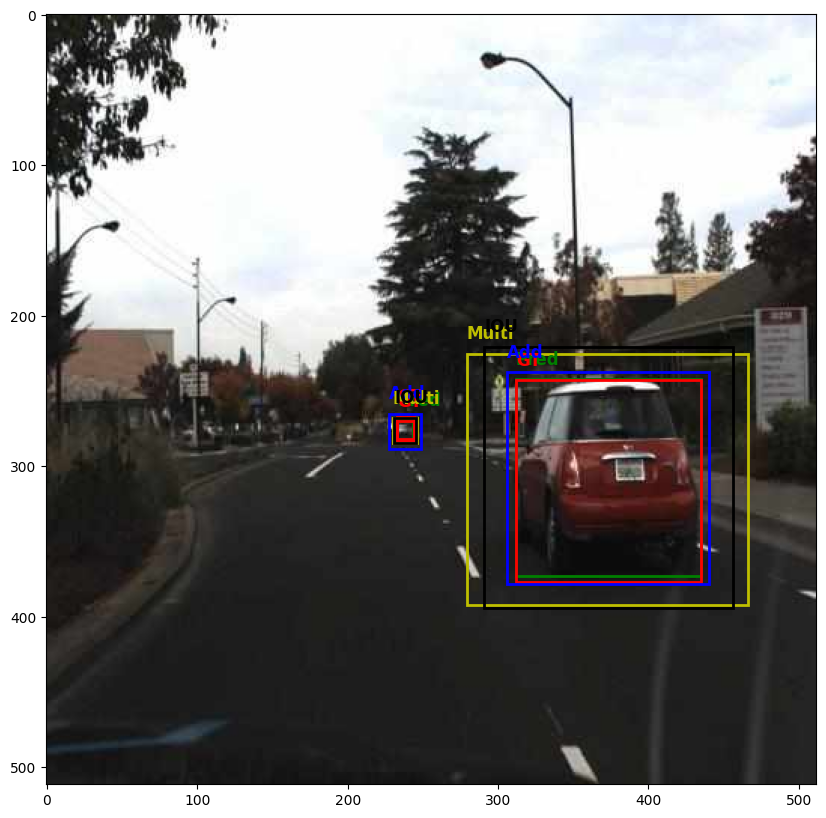

In [37]:

PRED_COLOR = 'g'   
GT_COLOR = 'r'    
ADD_COLOR = 'b'   
MULTI_COLOR = 'y' 
IOU_COLOR = 'k'

def draw_boxes(ax, boxes, color, label):
    for box in boxes:
        x_min, y_min, x_max, y_max = box[:4]
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        ax.text(x_min, y_min - 10, label, color=color, fontsize=12, weight='bold')
        

def visualize_boxes(image_file, preds, gts, img_width, img_height, add_intervals=None, multi_intervals=None, iou_intervals=None):
    
    image = cv2.imread(image_file)
    if image is None:
        print(f"Failed to load image: {image_file}")
        return
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    
    gt_boxes = [[(x_center - width / 2) * img_width, 
                 (y_center - height / 2) * img_height, 
                 (x_center + width / 2) * img_width, 
                 (y_center + height / 2) * img_height] for class_id, x_center, y_center, width, height in gts]

    
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image_rgb)

    
    draw_boxes(ax, preds, PRED_COLOR, 'Pred')

    
    draw_boxes(ax, gt_boxes, GT_COLOR, 'GT')
    
    
    if add_intervals is not None and len(add_intervals) > 0:
        draw_boxes(ax, add_intervals, ADD_COLOR, 'Add')

    if multi_intervals is not None and len(multi_intervals) > 0:
        draw_boxes(ax, multi_intervals, MULTI_COLOR, 'Multi')

    if iou_intervals is not None and len(iou_intervals) > 0:
        draw_boxes(ax, iou_intervals, IOU_COLOR, 'IOU')

    
    plt.show()


image_index = 22
if image_index >= len(test_image_files):
    raise IndexError("image_index 超出范围")

image_file = test_image_files[image_index]
preds = test_predictions[image_index]  
add_intervals = test_intervals_add[image_index]  
multi_intervals = test_intervals_mul[image_index]
iou_intervals = test_intervals_iou[image_index]

if isinstance(preds, list):
    preds = preds[0]

pred_bboxes = preds.boxes.xyxy.cpu().numpy() if hasattr(preds, 'boxes') else preds


gts = test_ground_truths[image_index]


img_width, img_height = 512, 512


visualize_boxes(image_file, pred_bboxes, gts, img_width, img_height, add_intervals,multi_intervals, iou_intervals)

In [19]:
def compute_iou(pred_box, gt_box):
    xA = max(pred_box[0], gt_box[0])
    yA = max(pred_box[1], gt_box[1])
    xB = min(pred_box[2], gt_box[2])
    yB = min(pred_box[3], gt_box[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (pred_box[2] - pred_box[0]) * (pred_box[3] - pred_box[1])
    boxBArea = (gt_box[2] - gt_box[0]) * (gt_box[3] - gt_box[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

def is_fully_enclosed(pred_box, gt_box):
    return (pred_box[0] <= gt_box[0] and
            pred_box[1] <= gt_box[1] and
            pred_box[2] >= gt_box[2] and
            pred_box[3] >= gt_box[3])

def calculate_coverage(ground_truths, confidence_intervals, pred_classes, iou_threshold):
    covered_count = 0
    total_gt_boxes = sum(len(gts) for gts in ground_truths)
    img_width = 512
    img_height = 512

    for preds, pred_cls, gts in zip(confidence_intervals, pred_classes, ground_truths):
        gt_bboxes = [[(x_center - width / 2) * img_width, 
                      (y_center - height / 2) * img_height, 
                      (x_center + width / 2) * img_width, 
                      (y_center + height / 2) * img_height,
                      class_id] 
                     for (class_id, x_center, y_center, width, height) in gts]
        
        for gt_box in gt_bboxes:
            gt_class_id = gt_box[4]
            best_iou = 0
            best_pred_box = None

            for pred_box, pred_class_id in zip(preds, pred_cls):
                if pred_class_id == gt_class_id:
                    iou = compute_iou(pred_box, gt_box[:4])
                    if iou > best_iou:
                        best_iou = iou
                        best_pred_box = pred_box
            
            if best_pred_box is not None:
                if is_fully_enclosed(best_pred_box, gt_box[:4]):
                    covered_count += 1
    coverage_rate = covered_count / total_gt_boxes if total_gt_boxes > 0 else 0
    return coverage_rate


In [38]:
coverage = calculate_coverage(test_ground_truths, test_intervals_iou,test_classes,0.5)

In [39]:
print (coverage)

0.8352713178294574


In [40]:
coverage_add = calculate_coverage(test_ground_truths, test_intervals_add,test_classes,0.5)
print (coverage_add)

0.8568974630021141


In [41]:
coverage_mul = calculate_coverage(test_ground_truths, test_intervals_mul,test_classes,0.5)
print (coverage_add)

0.8568974630021141


In [33]:
print (class_quantiles)

{0: 0.5573625564575195, 1: 0.6173133850097656, 2: 0.7218751609325409, 3: 0.6640479564666748, 4: 0.6497926414012909, 5: 0.6922534704208374, 6: 0.5999519228935242, 7: 0.6915315389633179, 8: 0.6983814835548401, 9: 0.6647312045097351, 10: 0.734189510345459}


In [42]:
coverage_none = calculate_coverage(test_ground_truths, test_predictions,test_classes,0.5)
print (coverage_none)

0.08086680761099366
